<a href="https://colab.research.google.com/github/JP200357/ATTP-Module-2-Exam/blob/main/ATTP_Mountain_car_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

**Mountain car-v0 Environment**



(b) Implement a neural network policy πθ(a|s) with parameters θ, mapping state vectors s
to action probabilities using a softmax output layer.

In [106]:
#Set up the Mountain car-v0 environment
env = gym.make("MountainCar-v0", render_mode="rgb_array")

state_dim = 2        # position,velocity
action_dim = env.action_space.n  # 3 discrete actions: left, no push, right

print(f"State dimension: {state_dim}, Action dimension: {action_dim}")

State dimension: 2, Action dimension: 3


In [107]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)  # Output probabilities for actions
        )

    def forward(self, state):
        return self.fc(state)

In [108]:
def select_action(policy, state):
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    action_probs = policy(state).squeeze(0)
    action_dist = torch.distributions.Categorical(probs=action_probs)
    action = action_dist.sample()
    return action.item(), action_dist.log_prob(action)

In [109]:
# Initialize policy network
policy = PolicyNetwork(state_dim, action_dim)

# Text action sampling
dummy_state = np.array([-0.5, 0.0], dtype=np.float32)
action, log_prob = select_action(policy,dummy_state)
print(f"Sampled action: {action}, Log-probability: {log_prob.item()}")

Sampled action: 0, Log-probability: -1.0599186420440674


In [110]:
def collect_trajectory(policy, env, max_steps=500):
    states, actions, log_probs, rewards = [], [], [], []
    state, _ = env.reset()
    state = np.array([np.random.uniform(-0.6, -0.4), 0.0], dtype=np.float32)

    # The trajectory can be max_steps long
    for _ in range(max_steps):

        # For EACH step, we want to store the action and log( pi(a|s) )
        action, log_prob = select_action(policy, state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Reward shaping for MountainCar
        position, velocity = state
        if position >= 0.5:  # goal
            reward += 100.0
        reward += (position + 0.5) * 10
        reward += (velocity ** 2) * 50.0
        if 0.3 < position < 0.5:
            reward += (position - 0.3) * 20.0

        #Store data
        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)
        rewards.append(reward)

        if done:
            break

        # Prepare state for next iteration of for loop
        state = next_state

    return states, actions, log_probs, rewards


In [111]:
def compute_returns(rewards, gamma=0.99):
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)  #Insert at the beginning
    returns = np.array(returns)
    if len(returns) > 1:
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns.tolist()

In [112]:
optimizer = optim.Adam(policy.parameters())
def reinforce_update(policy, optimizer, states, actions, returns):
    states_tensor = torch.tensor(np.array(states), dtype=torch.float32)
    actions_tensor = torch.tensor(actions, dtype=torch.int64)
    returns_tensor = torch.tensor(returns, dtype=torch.float32)

    # normalize returns
    returns_tensor = (returns_tensor - returns_tensor.mean()) / (returns_tensor.std() + 1e-8)

    probs = policy(states_tensor)
    dist = torch.distributions.Categorical(probs)
    log_probs = dist.log_prob(actions_tensor)

    # Standard REINFORCE loss
    loss = -(log_probs * returns_tensor).sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return returns_tensor.mean().item()


(c) Train your agent and plot the average return per
episode.

Episode   50 | Average return (last 50): -256.8
Episode  100 | Average return (last 50): -234.6
Episode  150 | Average return (last 50): -218.5
Episode  200 | Average return (last 50): -148.6
Episode  250 | Average return (last 50): -43.2
Episode  300 | Average return (last 50): 30.0
Episode  350 | Average return (last 50): 44.5
Episode  400 | Average return (last 50): 43.7
Episode  450 | Average return (last 50): 44.7
Episode  500 | Average return (last 50): 47.9
Episode  550 | Average return (last 50): 43.8
Episode  600 | Average return (last 50): 42.6
Episode  650 | Average return (last 50): 46.7
Episode  700 | Average return (last 50): 45.3
Episode  750 | Average return (last 50): 48.3
Episode  800 | Average return (last 50): 41.9
Episode  850 | Average return (last 50): 45.9
Episode  900 | Average return (last 50): 46.3
Episode  950 | Average return (last 50): 48.7
Episode 1000 | Average return (last 50): 48.8


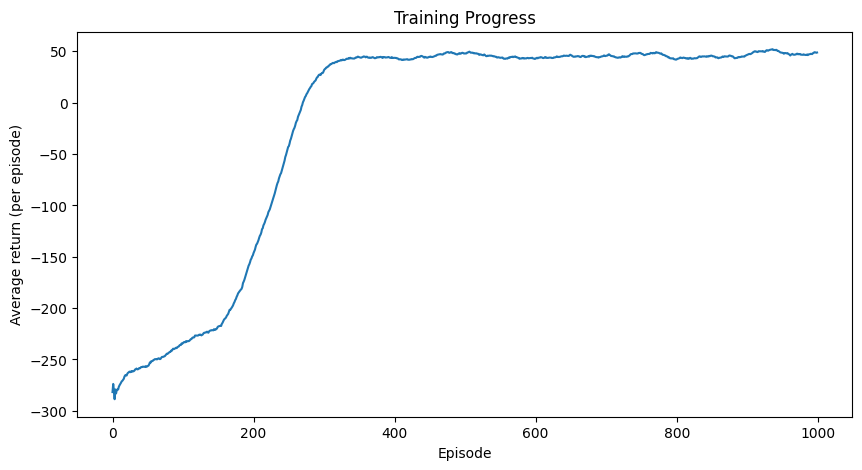

In [113]:
#Training loop
def main():
    num_episodes = 1000
    batch_size = 4
    episode_rewards = []

    buffer_states, buffer_actions, buffer_returns = [], [], []

    for episode in range(num_episodes):
        states, actions, log_probs, rewards = collect_trajectory(policy, env)
        returns = compute_returns(rewards)
        buffer_states.extend(states)
        buffer_actions.extend(actions)
        buffer_returns.extend(returns)
        episode_rewards.append(sum(rewards))

        if (episode + 1) % batch_size == 0:
            reinforce_update(policy, optimizer, buffer_states, buffer_actions, buffer_returns)
            buffer_states, buffer_actions, buffer_returns = [], [], []

        if (episode + 1) % 50 == 0:
            avg_return = np.mean(episode_rewards[-50:])
            print(f"Episode {episode+1:4d} | Average return (last 50): {avg_return:.1f}")

    # Plot average return per episode AFTER training
    moving_avg = [np.mean(episode_rewards[max(0, i-49):i+1]) for i in range(len(episode_rewards))]
    plt.figure(figsize=(10,5))
    plt.plot(moving_avg)
    plt.xlabel("Episode")
    plt.ylabel("Average return (per episode)")
    plt.title("Training Progress")
    plt.show()

    env.close()


if __name__ == "__main__":
    main()
